Created by Nicole

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import datetime
import random
import matplotlib.pyplot as plt
# %matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import random_correlation
import scipy.optimize as optimize
import scipy.interpolate as sci
import time
from datetime import datetime as dt
import tqdm

import import_ipynb

import tensorflow as tf
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials, space_eval
from hyperopt import rand
import sys
import math

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
import itertools

c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

# Data

In [3]:
from data import Data

[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (41042, 8)


c:\Users\xiang\anaconda3\envs\RLcapstone\lib\site-packages\finrl\meta\preprocessor\yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


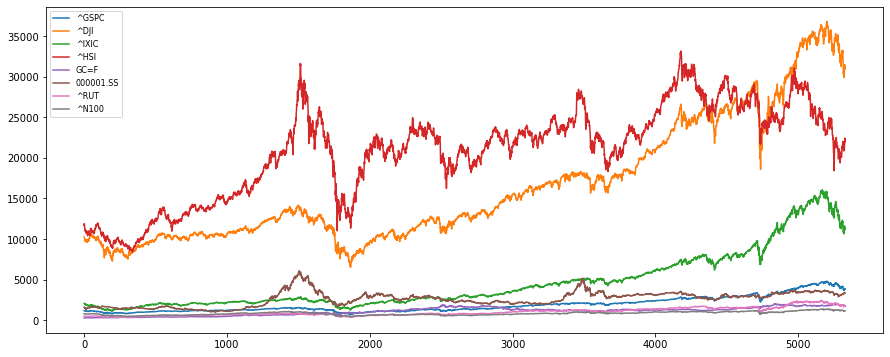

In [103]:
index_list = ['^GSPC', '^DJI', '^IXIC', '^HSI', 'GC=F', '000001.SS',  '^RUT', '^N100'] #'^BUK100P','IMOEX.ME'

data = Data(index_list, start_date='2002-01-01', end_date='2022-06-30', n_past=10, mvo_shift=20)
data.generate_df() 
X_train, X_valid, X_test, y_train, y_valid, y_test = data.get_train_test_data(normalize=False)
fig, ax = plt.subplots(1, figsize=(15, 6))
data.plot_data(ax=ax)
plt.show()

# Reinforcement Learning

In [5]:
from dql_models import RNNTrainer, LSTMTrainer, CNNTrainer, custom_loss

### Hyperparameter spaces for hyperopt to draw from

In [6]:
# range of space of parameters
rnn_space = {
    'Nodes1':64,
    'Nodes2':64,
    'Dropout1': hp.uniform('Dropout1', 0.0, 0.3),
    'Dropout2': hp.uniform('Dropout2', 0.0, 0.3),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 512),
    'lr': hp.uniform('lr', 0.0005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

lstm_space = {
    'Nodes1':32,
    'Nodes2':16,
    'Dropout1': hp.uniform('Dropout1', 0.0, 0.3),
    'Dropout2': hp.uniform('Dropout2', 0.0, 0.3),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 512),
    'lr': hp.uniform('lr', 0.0005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

cnn_space = {
    'Nodes1':16,
    'Nodes2':32,
    'Nodes4':32,
    'filter1_size1': hp.uniformint('filter1_size1', 2, 4),
    'filter1_size2': hp.uniformint('filter1_size2', 2, 4),
    'filter2_size1': hp.uniformint('filter2_size1', 2, 4),
    'filter2_size2': hp.uniformint('filter2_size2', 2, 4),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'Reg4': hp.uniform('Reg4', 0.0, 0.1),
    'dropout': hp.uniform('dropout', 0.0, 0.3),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 512),
    'lr': hp.uniform('lr', 0.005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

# Train models

In [31]:
rnn_trainer = RNNTrainer(rnn_space, data, opt='sortino', normalize = False, return_data = False) 
try:
    rnn_best = rnn_trainer.tune(10)
except Exception as e:
    import sys
    import traceback
    exc = sys.exc_info()
    traceback.print_exception(*exc)

25/25 [==============================] - 0s 3ms/step 

25/25 [==============================] - 0s 3ms/step                             

25/25 [==============================] - 0s 2ms/step                              

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 2ms/step                            

25/25 [==============================] - 0s 3ms/step                            

25/25 [==============================] - 0s 2ms/step                            

25/25 [==============================] - 0s 2ms/step                            

25/25 [==============================] - 0s 2ms/step                            

25/25 [==============================] - 0s 2ms/step                            

100%|██████████| 10/10 [12:54<00:00, 77.46s/trial, best loss: -0.5374625821391477]


In [32]:
rnn_best

{'Hyperparams': {'Dropout1': 0.231288410964849,
  'Dropout2': 0.08320024646060002,
  'Nodes1': 64,
  'Nodes2': 64,
  'Reg1': 0.022350249297470617,
  'Reg2': 0.0446246592912978,
  'batch_size': 285,
  'loss_fn': <function dql_models.custom_loss(y_true, y_pred)>,
  'lr': 0.032309511027954325,
  'momentum': 0.8204705827171495,
  'nesterov': False},
 'Opt': 'sortino',
 'Normalize': False,
 'Return_data': False,
 'time': '13_22_36',
 'History': <keras.callbacks.History at 0x256d1e82610>}

In [77]:
# exc[2].tb_next.tb_next.tb_next.tb_next.tb_next.tb_next.tb_frame.f_locals['self'].trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': nan,
   'status': 'ok',
   'model': <keras.engine.sequential.Sequential at 0x1b7b17e05b0>,
   'history': <keras.callbacks.History at 0x1b7b1888e20>},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'Dropout1': [0],
    'Dropout2': [0],
    'Reg1': [0],
    'Reg2': [0],
    'batch_size': [0],
    'loss_fn': [0],
    'lr': [0],
    'momentum': [0],
    'nesterov': [0]},
   'vals': {'Dropout1': [0.17031374170404776],
    'Dropout2': [0.06778125147460744],
    'Reg1': [0.06881654501974584],
    'Reg2': [0.06967668864326],
    'batch_size': [38.0],
    'loss_fn': [0],
    'lr': [0.0019878398022035123],
    'momentum': [0.8129353330597535],
    'nesterov': [1]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 8, 9, 1, 33, 17, 538000),
  'refresh_time': datetime.datetime(2022, 8, 9, 1, 35, 0, 381000)},
 {'state': 2,
  'tid': 1,
  '

In [33]:
lstm_trainer = LSTMTrainer(lstm_space, data, opt='sortino', normalize = False, return_data = False)
lstm_best = lstm_trainer.tune(10)

25/25 [==============================] - 0s 3ms/step 

25/25 [==============================] - 0s 6ms/step                             

25/25 [==============================] - 0s 6ms/step                             

25/25 [==============================] - 0s 6ms/step                              

25/25 [==============================] - 0s 6ms/step                              

25/25 [==============================] - 0s 6ms/step                              

25/25 [==============================] - 0s 5ms/step                              

25/25 [==============================] - 0s 5ms/step                              

25/25 [==============================] - 0s 4ms/step                              

25/25 [==============================] - 0s 4ms/step                              

100%|██████████| 10/10 [23:36<00:00, 141.70s/trial, best loss: -0.05621673243784442]


In [34]:
lstm_best

{'Hyperparams': {'Dropout1': 0.03263037312396413,
  'Dropout2': 0.05062927837388302,
  'Nodes1': 32,
  'Nodes2': 16,
  'Reg1': 0.09960237665562754,
  'Reg2': 0.09768932377061808,
  'batch_size': 387,
  'loss_fn': <function dql_models.custom_loss(y_true, y_pred)>,
  'lr': 0.03204589064363905,
  'momentum': 0.3003394063838074,
  'nesterov': True},
 'Opt': 'sortino',
 'Normalize': False,
 'Return_data': False,
 'time': '13_22_59',
 'History': <keras.callbacks.History at 0x256efc3e850>}

In [35]:
cnn_trainer = CNNTrainer(cnn_space, data, opt='sortino', normalize = False, return_data = True)
cnn_best = cnn_trainer.tune(10)

25/25 [==============================] - 0s 2ms/step 

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 1ms/step                             

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 2ms/step                             

25/25 [==============================] - 0s 1ms/step                             

25/25 [==============================] - 0s 2ms/step                             

100%|██████████| 10/10 [05:21<00:00, 32.18s/trial, best loss: -0.35470428634422535]


In [36]:
cnn_best

{'Hyperparams': {'Nodes1': 16,
  'Nodes2': 32,
  'Nodes4': 32,
  'Reg1': 0.07303757276031908,
  'Reg2': 0.03004015751315763,
  'Reg4': 0.01817306565260718,
  'batch_size': 503,
  'dropout': 0.21425971521639622,
  'filter1_size1': 3,
  'filter1_size2': 3,
  'filter2_size1': 4,
  'filter2_size2': 2,
  'loss_fn': <function dql_models.custom_loss(y_true, y_pred)>,
  'lr': 0.005750408940783194,
  'momentum': 0.18586809228032708,
  'nesterov': True},
 'Opt': 'sortino',
 'Normalize': False,
 'Return_data': True,
 'time': '13_23_05',
 'History': <keras.callbacks.History at 0x2571764bb80>}

#### save best parameters

In [275]:
import pickle
with open('Trained Models/rnn_best_sortino_non.pickle', 'wb') as f:
    pickle.dump(rnn_best, f)

with open('Trained Models/lstm_best_sortino_non.pickle', 'wb') as f:
    pickle.dump(lstm_best, f)

with open('Trained Models/cnn_best_sortino_non.pickle', 'wb') as f:
    pickle.dump(cnn_best, f)

# Testing models

In [257]:
# derived from previous best hyperparameters
# rnn_best = {
#     'Dropout1': 0.090,
#     'Dropout2':	0.037,
#     'Dropout3': 0.054,
#     'Nodes1':	64,
#     'Nodes2':	64,
#     'Nodes3':	64,
#     'Reg1':	0.063,
#     'Reg2':	0.054,
#     'Reg3':	0.023,
#     'batch_size':	108,
#     'loss_fn':	custom_loss,
#     'lr':	0.0001,
#     'momentum':	0.3564687815,
#     'nesterov':	False,
# }

# lstm_best = {
#     'Dropout1': 0.090,
#     'Dropout2':	0.037,
#     'Dropout3': 0.054,
#     'Nodes1': 64,
#     'Nodes2': 32,
#     'Nodes3': 16,
#     'Reg1':	0.063,
#     'Reg2':	0.054,
#     'Reg3':	0.023,
#     'batch_size':	108,
#     'loss_fn':	custom_loss,
#     'lr':	0.002798587134,
#     'momentum':	0.3564687815,
#     'nesterov':	False,
# }

cnn_best = {
    'Nodes1': 16,
    'Nodes2': 32,
    'Nodes4': 32,
    'filter1_size1': 2,
    'filter1_size2': 2,
    'filter2_size1': 3,
    'filter2_size2': 4,
    'Reg1': 0.02934677673884195,
    'Reg2': 0.07688644936503547,
    'Reg3': 0.03434352641370604,
    'Reg4': 0.018740521588227598,
    'batch_size': 115,
    'dropout': 0.046123862379318425,
    'loss_fn': custom_loss,
    'lr': 0.036297557245982374,
    'momentum': 0.9443862495512526,
    'nesterov': False
}


### Some useful functions

In [286]:
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

def test_model(model, X_test, y_test):        
    test_preds = model.predict(X_test)
    test_rets = np.array(tf.reduce_sum(test_preds * y_test, axis=1))
    test_sharpe = sharpe(test_rets)
    test_sortino = sortino(test_rets)
    test_total_ret = float(tf.reduce_prod(1 + test_rets) - 1)
    return {'sharpe':test_sharpe,'sortino':test_sortino,'total_return':test_total_ret,'predictions':test_preds,'daily_returns':test_rets}

def get_model_rets(model,X_test,y_test):
    return np.array(tf.reduce_sum(model.predict(X_test) * y_test, axis=1))

def plot_weights(model, X_test):
    preds = model.predict(X_test)
    plt.figure(figsize=(15, 6))
    for i in range(preds.shape[1]):
        plt.plot(preds[:,i],label=f'Stock {i+1}')
    plt.legend(loc='upper left', fontsize=8)

def plot_pf(rets, dates, label, ax):
    wealth = [100]
    for x in rets:
        wealth.append(wealth[-1]*(1+x))
    ax.plot(dates, wealth[1:], label=label)
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='minor', linestyle='-.') #plt.grid(axis='x', linestyle='-.')

def get_market_rets(X_test,y_test):
    mark = [X_test[i][0] for i in range(X_test.shape[0])]
    weights = np.array([mark[i]/mark[i].sum() for i in range(len(mark))])
    return np.array(tf.reduce_sum(y_test*weights,axis=1))

    
def sharpe(rets):
    total_ret = tf.reduce_prod(1 + rets) - 1
    return float(total_ret/np.std(rets))

def sortino(rets):
    neg_rets = rets[rets<0]
    total_ret = tf.reduce_prod(1 + rets) - 1
    return float(total_ret / np.std(neg_rets))

# def maxDrawdown(returns):
#     wealth = [100]
#     for x in returns:
#         wealth.append(wealth[-1]*(1+x))
#     wealth = np.array(wealth)
#     Roll_Max = np.maximum.accumulate(wealth)
#     Daily_Drawdown = wealth/Roll_Max - 1.0
#     Max_Daily_Drawdown = np.minimum.accumulate(wealth)

#     return Max_Daily_Drawdown[-1]

def maxDrawdown(returns):
    return_list = [100]
    for x in returns:
        return_list.append(return_list[-1]*(1+x))
    
    # 1. find all of the peak of cumlative return 
    maxcum = np.zeros(len(return_list))
    b = return_list[0]
    for i in range(0,len((return_list))):
        if (return_list[i]>b):
            b = return_list[i]
        maxcum[i] = b
    
    # 2. then find the max drawndown point
    i = np.argmax((maxcum-return_list)/maxcum) 
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])   
    
    # 3. return the maxdrawndown
    return ((return_list[j]-return_list[i])/return_list[j])*100

## Model comparison to benchmark

In [309]:
with open('params/cnn_best_sharpe_non.pkl', 'rb') as f:
    cnn_best = pickle.load(f)
cnn_best['loss_fn'] = custom_loss

with open('params/rnn_best_sharpe_non.pkl', 'rb') as f:
    rnn_best = pickle.load(f)
rnn_best['loss_fn'] = custom_loss

with open('params/lstm_best_sharpe_non.pkl', 'rb') as f:
    lstm_best = pickle.load(f)
lstm_best['loss_fn'] = custom_loss

# save to txt file
# with open('params/ bestpparams.txt', 'w') as f:
#     f.write(str(cnn_best))
#     f.write(str(rnn_best))
#     f.write(str(lstm_best))

25/25 [==============================] - 0s 2ms/step


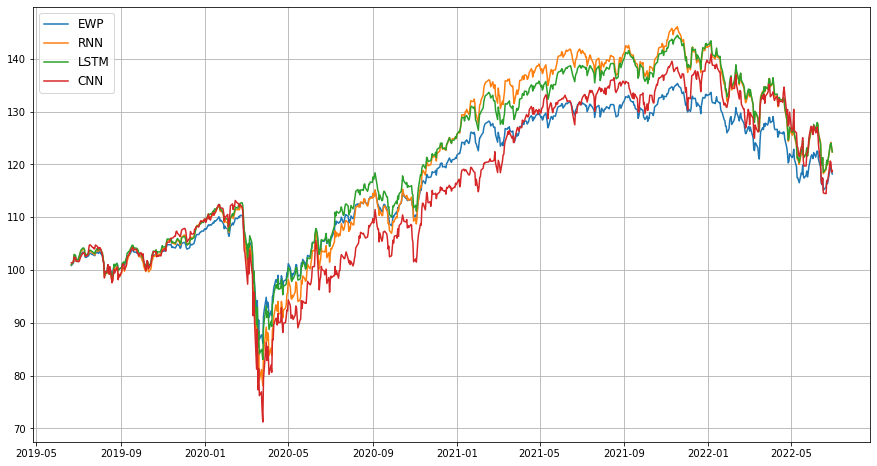

In [315]:

rnn_trainer = RNNTrainer(rnn_best, data, opt='sharpe', normalize=False, return_data=False)
rnn_model = rnn_trainer.get_model(rnn_best)
# rnn_model.load_weights('Trained Models/RNN_raw_sortino_09_00_04')
# rnn_model.load_weights('Trained Models/RNN_raw_sharpe_13_02_32') #nor
rnn_model.load_weights('Trained Models/RNN_raw_sharpe_13_13_12') #non-
# rnn_model.load_weights('Trained Models/RNN_raw_sortino_13_22_36') #non-
rnn_rets = get_model_rets(rnn_model, rnn_trainer.X_test, rnn_trainer.y_test)
lstm_trainer = LSTMTrainer(lstm_best, data, opt='sharpe', normalize=True, return_data=False)
lstm_model = lstm_trainer.get_model(lstm_best)
# lstm_model.load_weights('Trained Models/LSTM_raw_sharpe_09_00_35')
# lstm_model.load_weights('Trained Models/LSTM_raw_sharpe_13_03_00')#test_LSTM_raw_sharpe
lstm_model.load_weights('Trained Models/LSTM_raw_sharpe_13_13_21')
# lstm_model.load_weights('Trained Models/LSTM_raw_sortino_13_22_59')
lstm_rets = get_model_rets(lstm_model, lstm_trainer.X_test,lstm_trainer.y_test)
cnn_trainer = CNNTrainer(cnn_best,data, opt='sharpe',normalize=False,return_data=True)
cnn_model = cnn_trainer.get_model(cnn_best)
# cnn_model.load_weights('Trained Models/CNN_ret_sortino_09_00_43')
# cnn_model.load_weights('Trained Models/CNN_ret_sharpe_13_03_04')
cnn_model.load_weights('Trained Models/CNN_ret_sharpe_13_13_25')
# cnn_model.load_weights('Trained Models/CNN_ret_sortino_13_23_05')
cnn_rets = get_model_rets(cnn_model, cnn_trainer.X_test, cnn_trainer.y_test)
fig, ax1 = plt.subplots(1, sharex=True, figsize=(15,8))
plot_pf(ew_rets, dates[-(len(ew_rets) ):], 'EWP', ax1)
plot_pf(rnn_rets, dates[-(len(rnn_rets) ):] ,'RNN', ax1)
plot_pf(lstm_rets, dates[-(len(rnn_rets) ):] ,'LSTM', ax1)
plot_pf(cnn_rets, dates[-(len(rnn_rets) ):] ,'CNN', ax1)
ax1.legend(loc='upper left', fontsize=12)

25/25 [==============================] - 0s 3ms/step


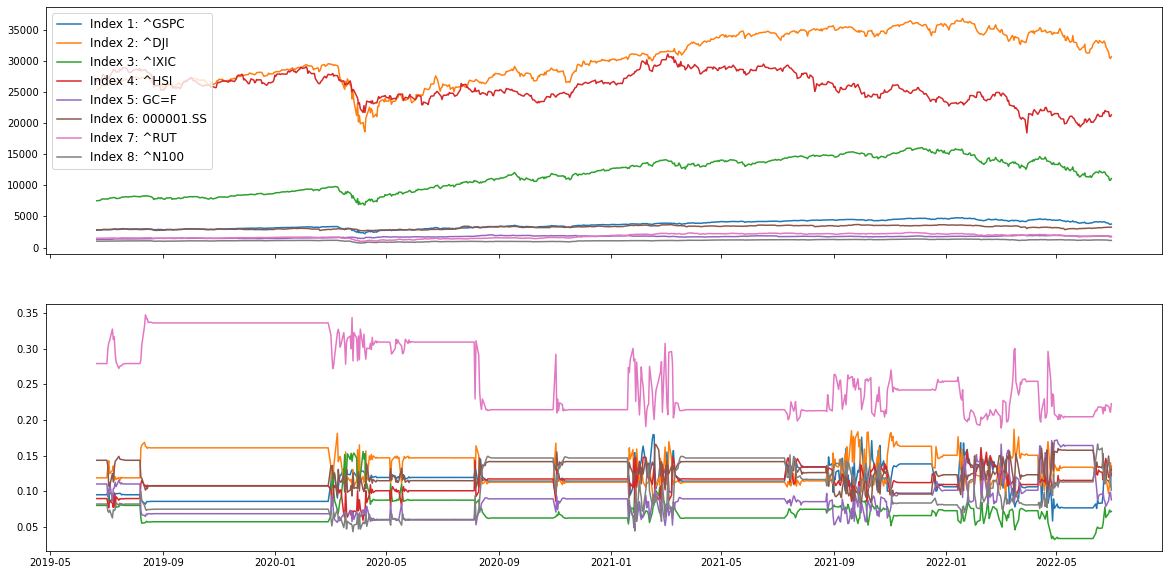

In [316]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(20,10))

preds = rnn_model.predict(X_test)
for i in range(preds.shape[1]):
    ax2.plot(
        dates[-(len(preds[:,i])) :], 
        preds[:,i],label=f'Index {i+1}: {data.prices.columns[i]}')

for i in range(X_test.shape[2]):
    ax1.plot(dates[-(len(X_test[:, 0, i])) :], X_test[:, 0, i], label=f'Index {i+1}: {data.prices.columns[i]}')
ax1.legend(loc='upper left', fontsize=12)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.xaxis.grid(True, which='minor', linestyle='-.') #plt.grid(axis='x', linestyle='-.')

In [37]:
print(cnn_model.summary())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 10, 8, 16)         208       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 5, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 5, 4, 32)          6176      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 32)              

In [38]:
lstm_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 10, 32)            5248      
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_46 (Dense)            (None, 8)                 136       
                                                                 
Total params: 8,520
Trainable params: 8,520
Non-trainable params: 0
_________________________________________________________________


In [39]:
rnn_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 10, 64)            4672      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 8)                 520       
                                                                 
Total params: 13,448
Trainable params: 13,448
Non-trainable params: 0
_________________________________________________________________


In [49]:
# lstm_model.save_weights(f'Trained Models/test_{test.nn_type}_{ test.data_type}_{test.opt}')

In [18]:
dot_img_file = 'Trained Models/RNN_sharpe_nor.png'
tf.keras.utils.plot_model(rnn_model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [238]:
# best parameters:
print(f'CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: {sharpe(cnn_rets)}, {sortino(cnn_rets)}, {maxDrawdown(cnn_rets)}, {float(tf.reduce_prod(1 + cnn_rets) - 1)}')
print(f'RNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(rnn_rets)}, {sortino(rnn_rets)}, {maxDrawdown(rnn_rets)}, {float(tf.reduce_prod(1 + rnn_rets) - 1)}')
print(f'LSTM Sharpe & Sortino& Max Drawdown & Cumulative Returns: : {sharpe(lstm_rets)}, {sortino(lstm_rets)}, {maxDrawdown(lstm_rets)}, {float(tf.reduce_prod(1 + lstm_rets) - 1)}')
print(f'EW Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(ew_rets)}, {sortino(ew_rets)}, {maxDrawdown(ew_rets)}, {float(tf.reduce_prod(1 + ew_rets) - 1)}')

CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: 21.59883920462193, 24.529213278140165, 33.92496000265329, 0.3215454295371907
RNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 18.93100702545376, 21.666821008542236, 29.228593232605114, 0.21579741743006076
LSTM Sharpe & Sortino& Max Drawdown & Cumulative Returns: : 22.791590824270884, 26.463425444652064, 25.44045334167337, 0.22686587861937646
EW Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 21.677016107700858, 25.15349701997451, [21.93479891], 0.1817853711896824


## Comparison of CNN and Markowitz

In [144]:
from mvoOptimizer import compare_strategy

In [153]:
# reload Data package
import importlib
import mvoOptimizer
importlib.reload(mvoOptimizer)
from mvoOptimizer import compare_strategy

In [253]:
dates = pd.date_range(start=data.start_date, end=data.end_date, freq='B')

In [317]:
dt.strftime((dates[(len(X_train))]), '%Y-%m-%d') 

'2016-04-04'

In [152]:
dt.strftime((dates[-(len(X_test))]), '%Y-%m-%d') 

'2019-06-21'

25/25 [==============================] - 0s 3ms/step


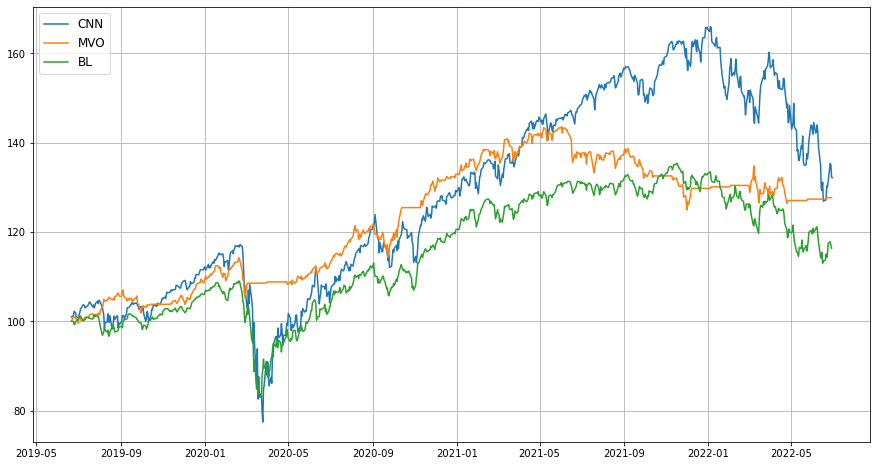

In [241]:
# in-sample 

cnn_rets = get_model_rets(cnn_model, cnn_trainer.X_test, cnn_trainer.y_test)
compare=compare_strategy(data, '2019-06-21',interest_rate=0.03/12, min_return = 0.03)
marko_rets = compare.Markowitz()
marko_rets.index = pd.to_datetime(marko_rets.index, format='%Y-%m-%d')
bl_rets = compare.bl_model()
bl_rets.index = pd.to_datetime(bl_rets.index, format='%Y-%m-%d')
fig, ax1 = plt.subplots(1, sharex=True, figsize=(15,8))
plot_pf(cnn_rets, dates[-(len(X_test)):], 'CNN', ax1)
ax1.plot(marko_rets.index, marko_rets*100, label='MVO')
ax1.plot(bl_rets.index, bl_rets*100, label='BL')
ax1.legend(loc='upper left', fontsize=12)

In [242]:
marko_rets = marko_rets.diff()[1:]
bl_rets = bl_rets.diff()[1:]
print(f'CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: {sharpe(cnn_rets)}, {sortino(cnn_rets)}, {MaxDrawdown(cnn_rets)}, {float(tf.reduce_prod(1 + cnn_rets) - 1)}')
print(f'Markowitz Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(marko_rets)}, {sortino(marko_rets)}, {MaxDrawdown(marko_rets)}, {float(tf.reduce_prod(1 + marko_rets) - 1)}')
print(f'Black-Litterman Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(bl_rets)}, {sortino(bl_rets)}, {MaxDrawdown(bl_rets)}, {float(tf.reduce_prod(1 + bl_rets) - 1)}')

CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: 21.59883920462193, 24.529213278140165, 33.92496000265329, 0.3215454295371907
Markowitz Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 39.28428196457798, 42.46507042986482, 17.44823650818572, 0.2907040713860052
Black-Litterman Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 13.96907599661187, 16.82862683495576, 23.67199194338155, 0.13480575146954132


In [243]:
dates = pd.date_range(start='2012-01-01', end='2016-04-01', freq='B')
len(dates)

1110

117/117 [==============================] - 0s 3ms/step


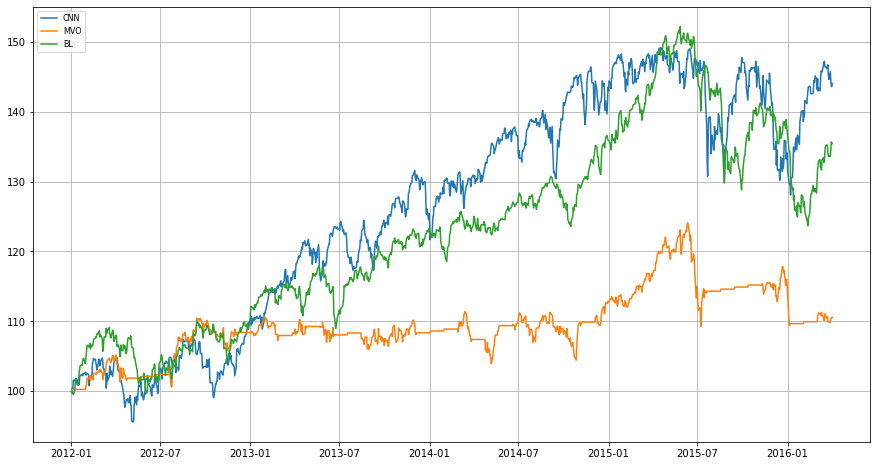

In [247]:
# out-sample 
compare=compare_strategy(data, '2012-01-03',interest_rate=0.03/12, min_return = 0.03)
cnn_rets = get_model_rets(cnn_model, cnn_trainer.X_train, cnn_trainer.y_train)
marko_rets = compare.Markowitz()
marko_rets.index = pd.to_datetime(marko_rets.index, format='%Y-%m-%d')
bl_rets = compare.bl_model()
bl_rets.index = pd.to_datetime(bl_rets.index, format='%Y-%m-%d')
# marko_rets[:1104]
fig, ax1 = plt.subplots(1, sharex=True, figsize=(15,8))
plot_pf(cnn_rets[-len(dates):], dates, 'CNN', ax1)
ax1.plot(marko_rets.index[:1104], marko_rets[:1104]*100, label='MVO')
ax1.plot(bl_rets.index[:1104], bl_rets[:1104]*100, label='BL')

ax1.legend(loc='upper left', fontsize=8)

In [250]:
# compare=compare_strategy(data, '2012-01-03',interest_rate=0.03/12, min_return = 0.03)
# marko_rets = compare.Markowitz()[:1104]
# marko_rets.index = pd.to_datetime(marko_rets.index, format='%Y-%m-%d')
# marko_rets = marko_rets.diff()[1:]
# bl_rets = bl_rets.diff()[1:]
print(f'CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: {sharpe(cnn_rets)}, {sortino(cnn_rets)}, {maxDrawdown(cnn_rets)}, {float(tf.reduce_prod(1 + cnn_rets) - 1)}')
print(f'Markowitz Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(marko_rets)}, {sortino(marko_rets)}, {maxDrawdown(marko_rets)}, {float(tf.reduce_prod(1 + marko_rets) - 1)-1}')
print(f'Black-Litterman Sharpe & Sortino & Max Drawdown & Cumulative Returns: : {sharpe(bl_rets)}, {sortino(bl_rets)}, {maxDrawdown(bl_rets)}, {float(tf.reduce_prod(1 + bl_rets) - 1)-1}')

CNN Sharpe & Sortino & Max Drawdown & Cumulative Returns: 64.65580007221001, 84.06003948732331, 53.97156473143816, 0.7443369180501274
Markowitz Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 178.40523145236043, 178.18967504950052, 18.715625372041796, 0.2103879665244368
Black-Litterman Sharpe & Sortino & Max Drawdown & Cumulative Returns: : 128.87178824374018, 150.3820237632423, 39.23602258190747, 0.4600148716753041


## Plot of the change in CNN allocations

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e2fe652-9345-434d-a8f2-b4c9fce078c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>